In [1]:
import neuron
from neuron import h
from neuron.units import ms, mV
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
from IPython.display import clear_output
%matplotlib inline

h.load_file('stdrun.hoc')
neuron.load_mechanisms('mechanisms')
h.load_file('templates/templates.hoc') # reads in template

h.dt = 0.025 # time step (resolution) of the simulation in ms
h.celsius = 36.0

In [2]:
Cell = 'CP_Cell'
settings = {
    'sec_id': 1,
    'sec_x': 0.4,
    'syn_type': 'AMPA_NMDA_STP',
    'tstart': 500,
    'tdur': 1500,
    'threshold': 0, # netcon
    'delay': 10, # netcon
    'weight': 1, # netcon
}

In [3]:
tstart = settings['tstart']
tdur = settings['tdur']
h.tstop = tstart + tdur # how long to run the simulation in ms

cell = getattr(h, Cell)()
syn = getattr(h,settings['syn_type'])(list(cell.all)[settings['sec_id']](settings['sec_x']))
nstim = h.NetStim()
nstim.start = tstart
nstim.noise = 0
nc = h.NetCon(nstim, syn, settings['threshold'], settings['delay'], settings['weight'])

t = h.Vector() # Vectors are used to record data in the simulation
soma_v = h.Vector()
i = h.Vector()
Use_rec = h.Vector()
Pr = h.Vector()
soma_v.record(cell.soma[0](0.5)._ref_v)
i.record(syn._ref_i)
Pr.record(syn._ref_record_Pr)
Use_rec.record(syn._ref_record_use)

t.record(h._ref_t) # derefences and records data

Vector[0]

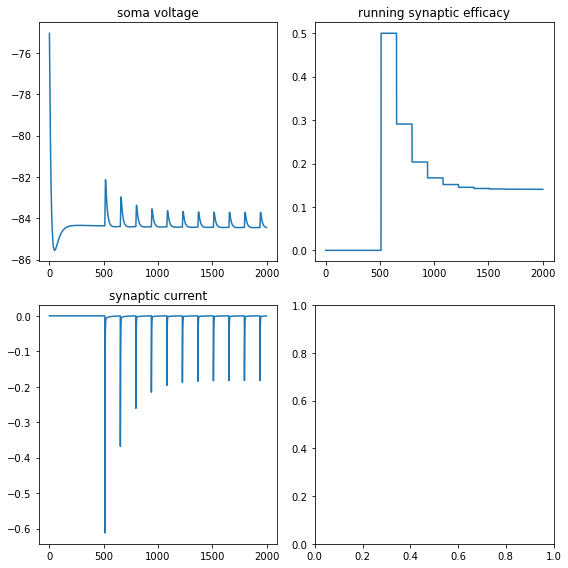

In [4]:
def model(weight, input_frequency, Use, tau_f, tau_d):
    nstim.interval = 1000 / input_frequency
    nstim.number = np.ceil(tdur / 1000 * input_frequency + 1)
    syn.initW = weight #synaptic weight for our synapse
    syn.Fac = tau_f
    syn.Dep = tau_d
    syn.Use = Use
    h.finitialize(cell.Vinit * mV)
    h.continuerun(h.tstop * ms)
    
    plot_model(t,soma_v,i,Pr,Use_rec)
    
def plot_model(t,soma_v,i,Pr,Use):
    fig = plt.figure(figsize=(8, 8),tight_layout=True) 
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1],height_ratios=[1,1]) 
    
    ax0 = plt.subplot(gs[0,0])
    ax1 = plt.subplot(gs[1,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,1])
    
    ax0.plot(t ,soma_v)
    ax0.set_title('soma voltage')
    
    ax1.plot(t,i)
    ax1.set_title('synaptic current')
    
    ax2.plot(t,Pr)
    ax2.set_title("running synaptic efficacy")
    

    plt.show()
    
weight = 15    
input_frequency = 7
Use = 1
tau_f = 10
tau_d = 100


w_run = widgets.Button(description='Run',icon='history',button_style='primary')
w_dep_model = widgets.Button(description='Depressing syn',icon='history',button_style='')    
w_fac_model = widgets.Button(description='Faciliating syn',icon='history',button_style='')        
w_weight = widgets.FloatSlider(value=weight,min=0.001,max=50, step=1,description='syn weight')
w_input_frequency = widgets.FloatSlider(value=input_frequency,min=0.001,max=50, step=1,description='Input Freq')
w_Use = widgets.FloatSlider(value=Use,min=0.001,max=1, step=0.01,description='init efficacy')
w_tau_f = widgets.FloatSlider(value=tau_f,min=0,max=2000, step=10,description='tau f')
w_tau_d = widgets.FloatSlider(value=tau_d,min=0,max=2000, step=10,description='tau d')

def run_model(*arges):
    clear_output()
    weight = w_weight.value
    input_frequency = w_input_frequency.value
    Use = w_Use.value
    tau_f = w_tau_f.value
    tau_d = w_tau_d.value
    display(ui)
    model(weight,input_frequency,Use,tau_f,tau_d)

def depressing_model(*arges):
    clear_output()
    print("changing synaptic values!")
    w_Use.value = 0.5
    w_tau_d.value = 800
    w_tau_f.value = 0
    display(ui)

def fac_model(*arges):
    clear_output()
    print("changing synaptic values!")
    w_Use.value = 0.03
    w_tau_d.value = 300
    w_tau_f.value = 1800
    display(ui)

w_run.on_click(run_model)
w_dep_model.on_click(depressing_model)
w_fac_model.on_click(fac_model) 
ui = VBox([HBox([w_run,w_dep_model,w_fac_model,w_Use]), HBox([w_weight,w_tau_f]),HBox([w_input_frequency,w_tau_d])])
ui